In [1]:
from src.neural_ot import NeuralOptimalTransport
from torch.optim import Adam
from src.data_samplers import TetrahedronGaussianSampler, LinkedTorusSampler
from src.utils import plot_generated_3D

from tqdm import tqdm

In [2]:
n_ot = NeuralOptimalTransport().to("cuda:0")
n_ot.count_params()

T params: 34179
f params: 33665


In [3]:
f_LR, T_LR = 1e-4, 1e-4

T_opt = Adam(
    n_ot.T.parameters(),
    lr=T_LR,
    weight_decay=0
)

f_opt = Adam(
    n_ot.f.parameters(),
    lr=f_LR,
    weight_decay=0
)  

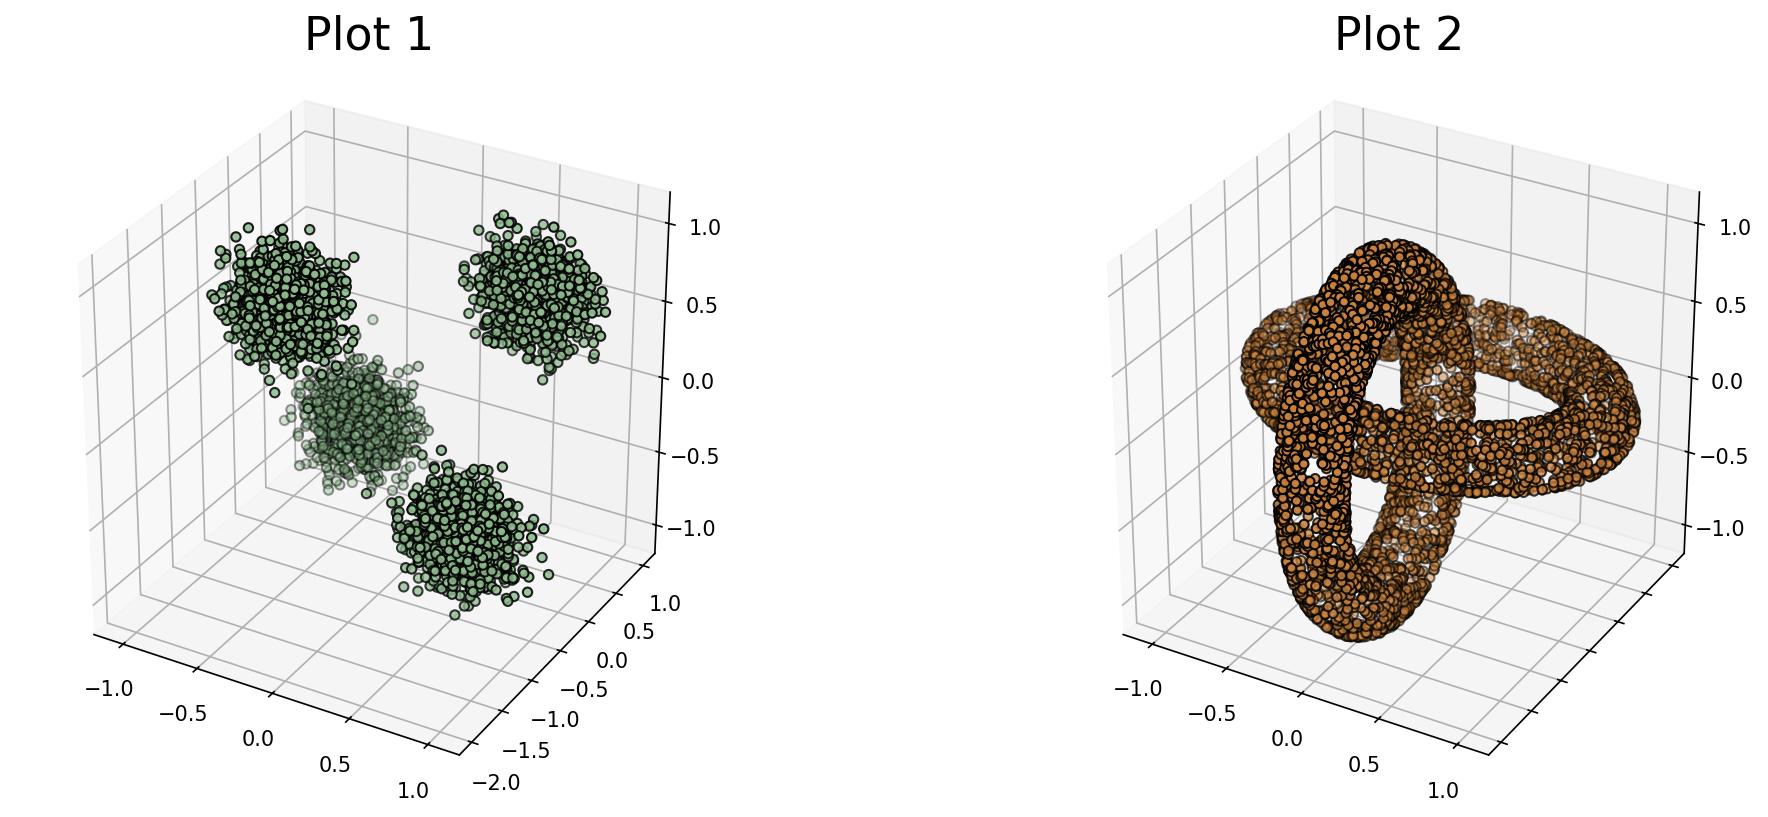

In [4]:
p_0 = TetrahedronGaussianSampler()
p_1 = LinkedTorusSampler()
plot_generated_3D([
    p_0.sample(batch_size=5000),
    p_1.sample(batch_size=5000)
]);

  0%|          | 0/250005 [00:00<?, ?it/s]

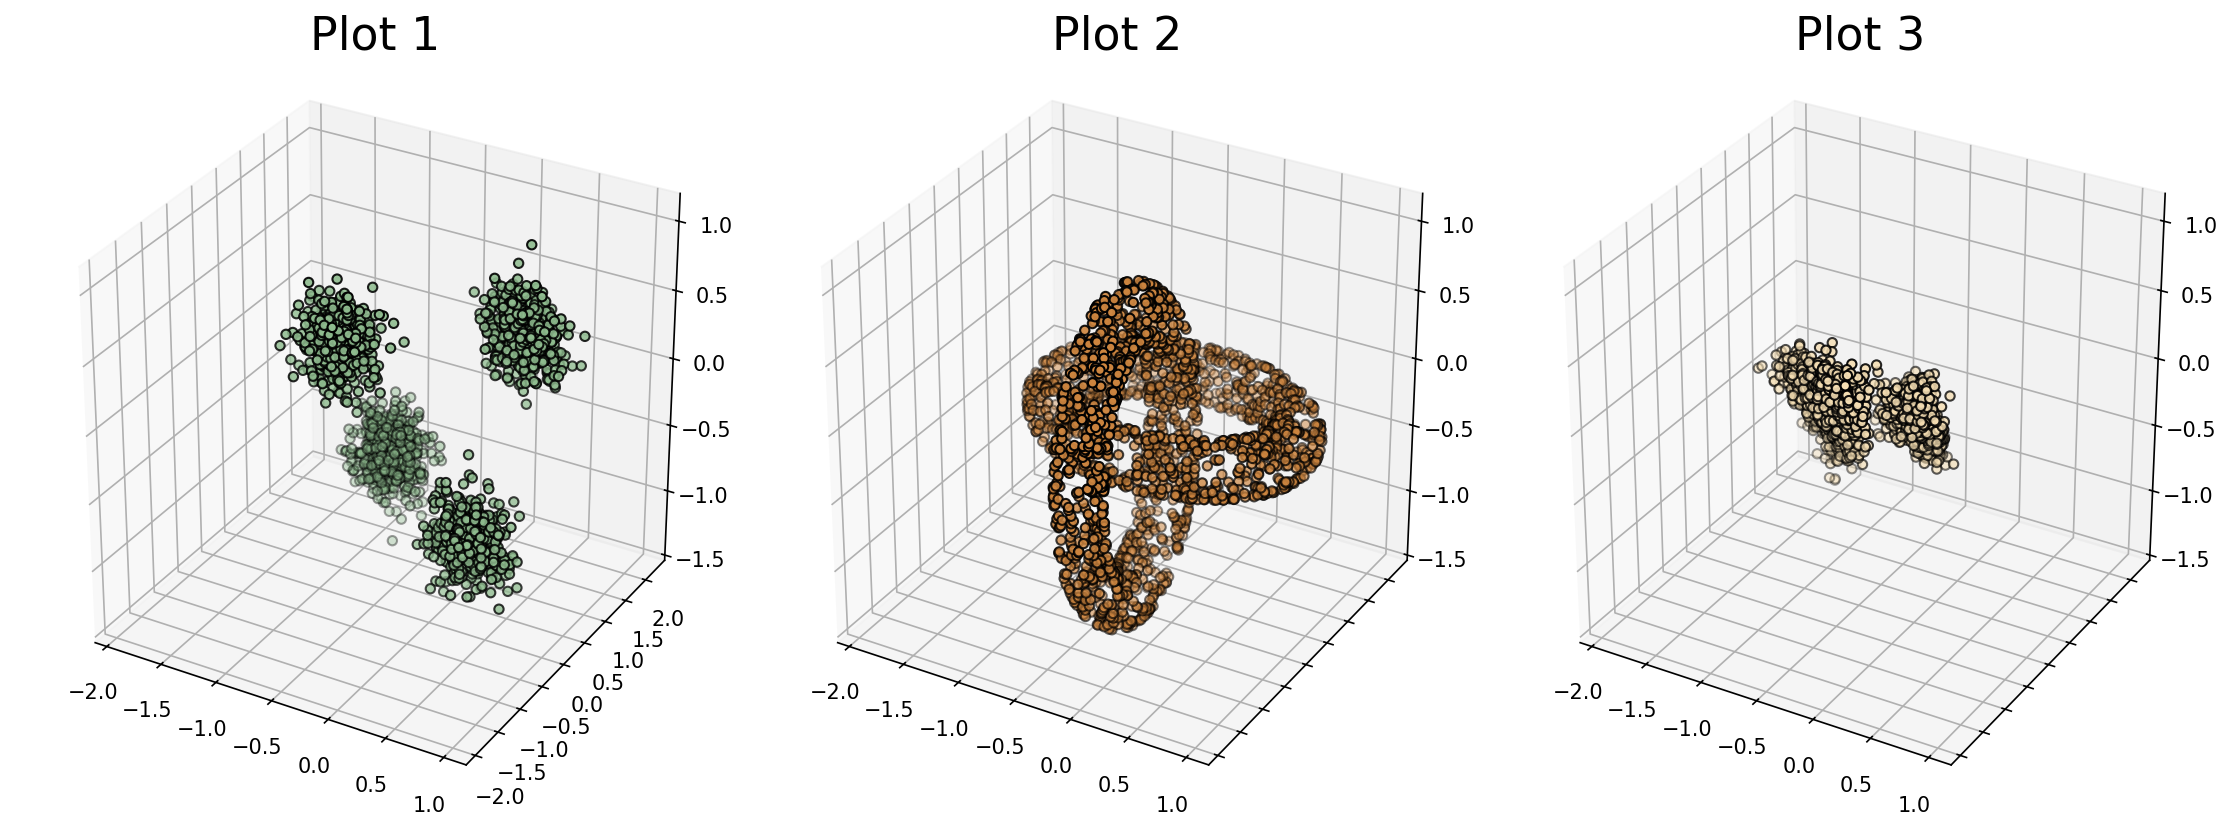

  0%|          | 997/250005 [00:05<17:41, 234.56it/s]

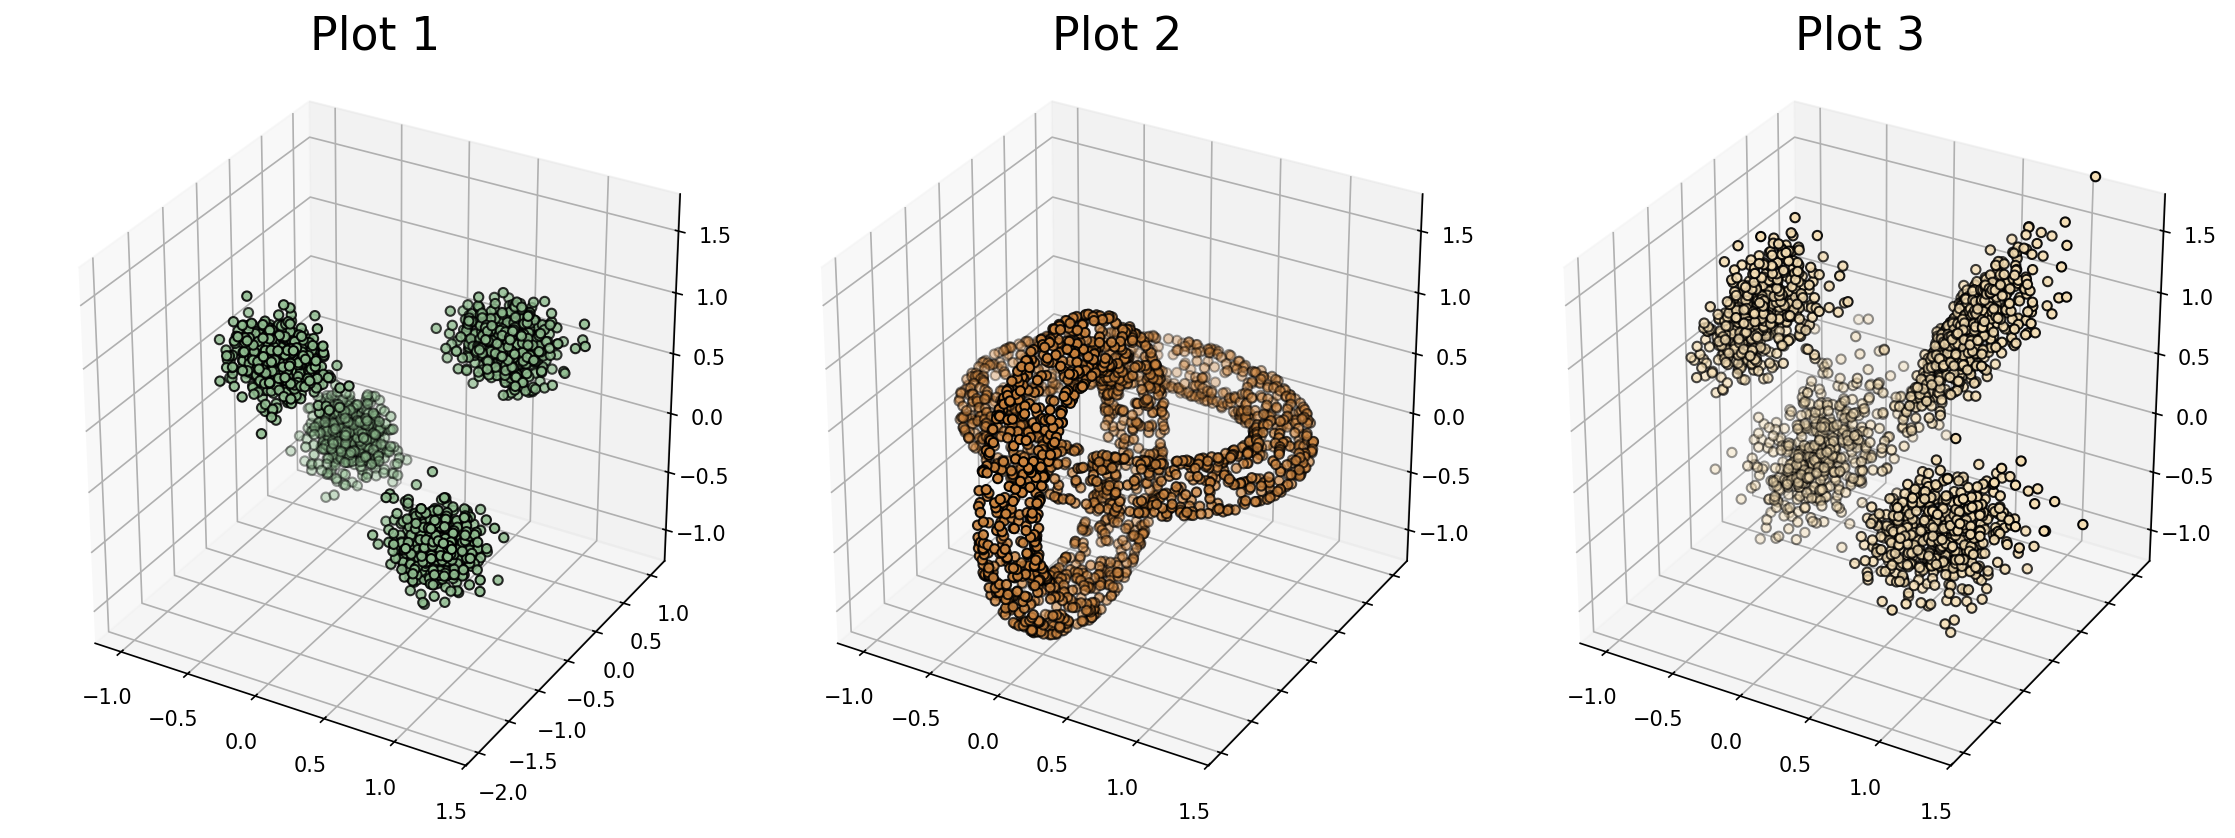

  1%|          | 1981/250005 [00:09<17:38, 234.30it/s]

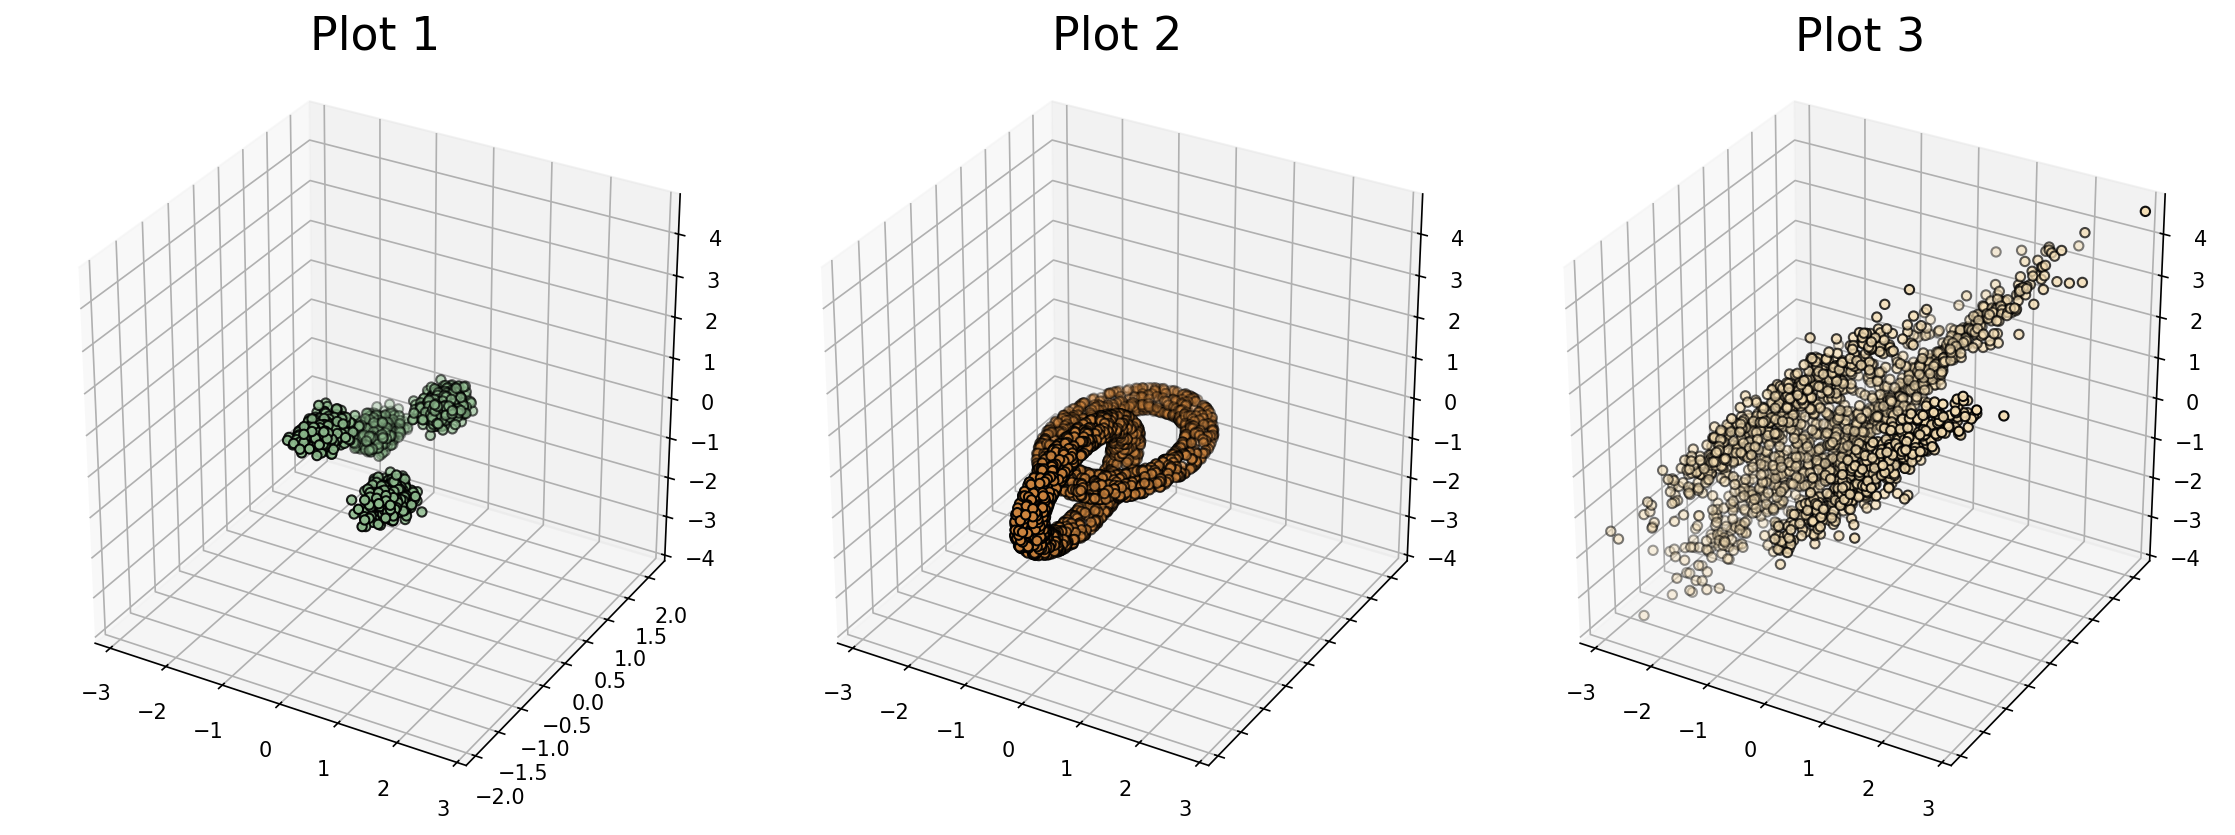

  1%|          | 2989/250005 [00:14<17:34, 234.23it/s]

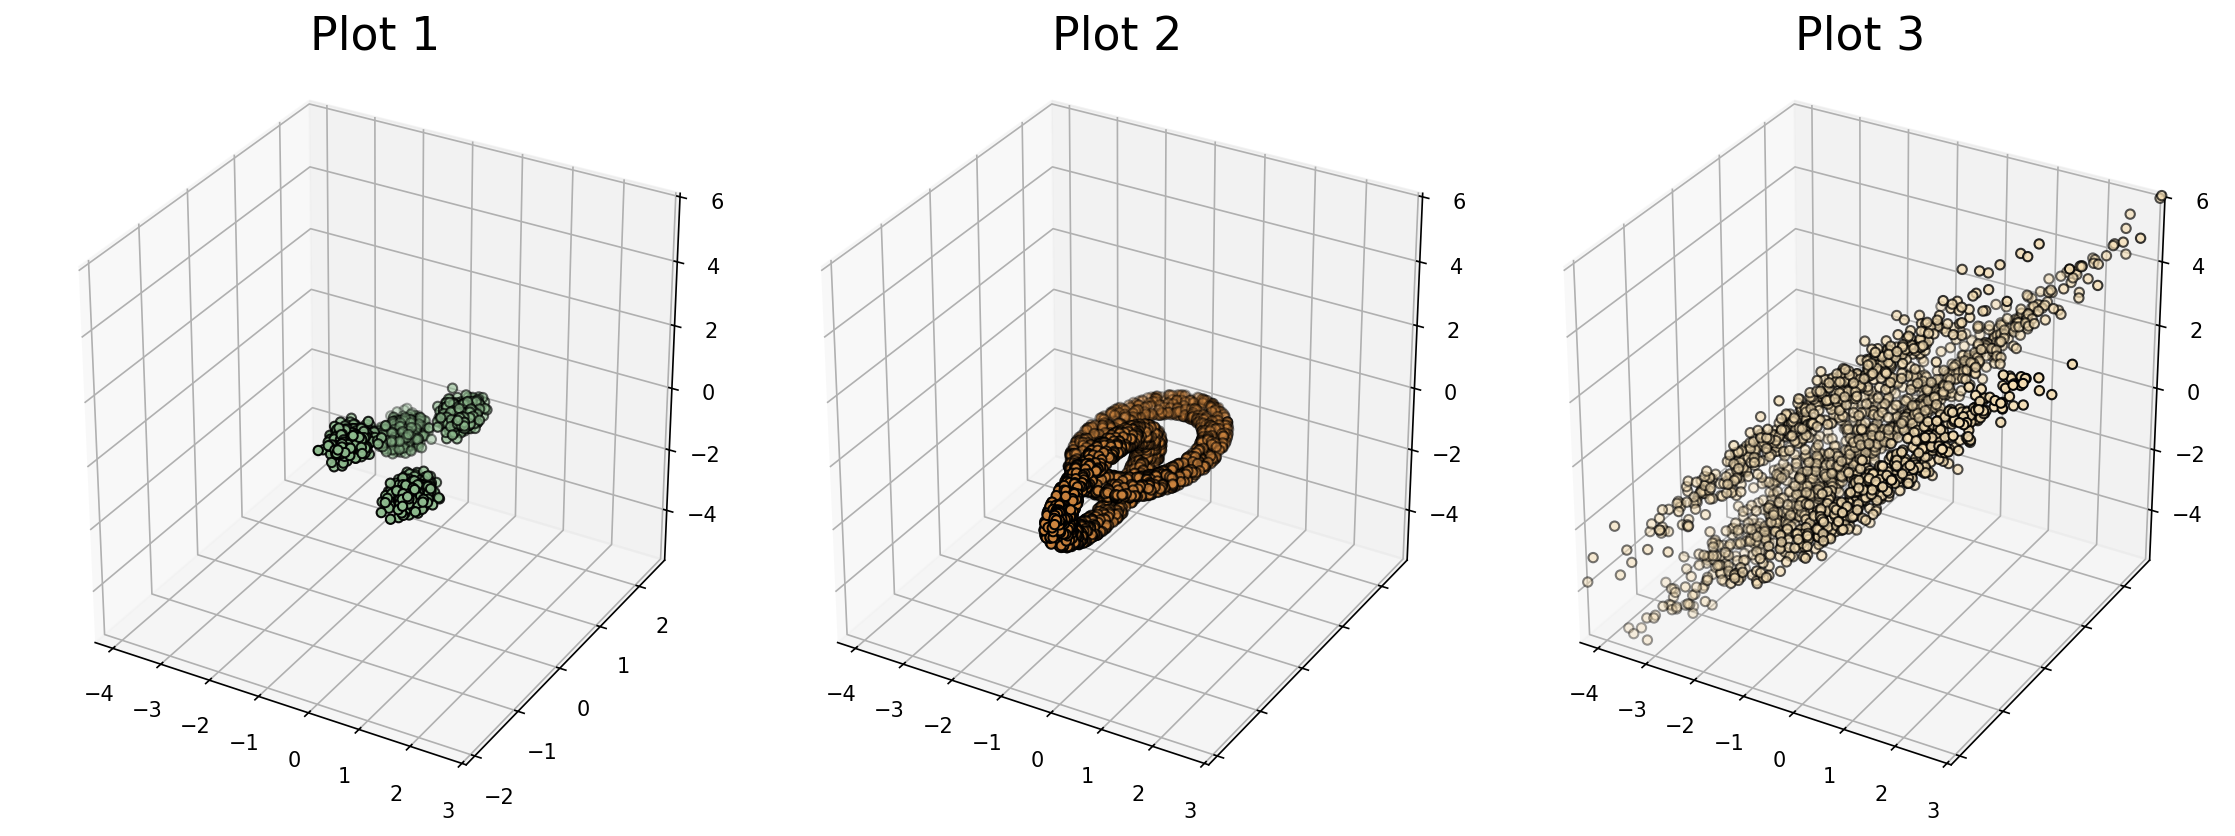

  2%|▏         | 3997/250005 [00:19<17:33, 233.48it/s]

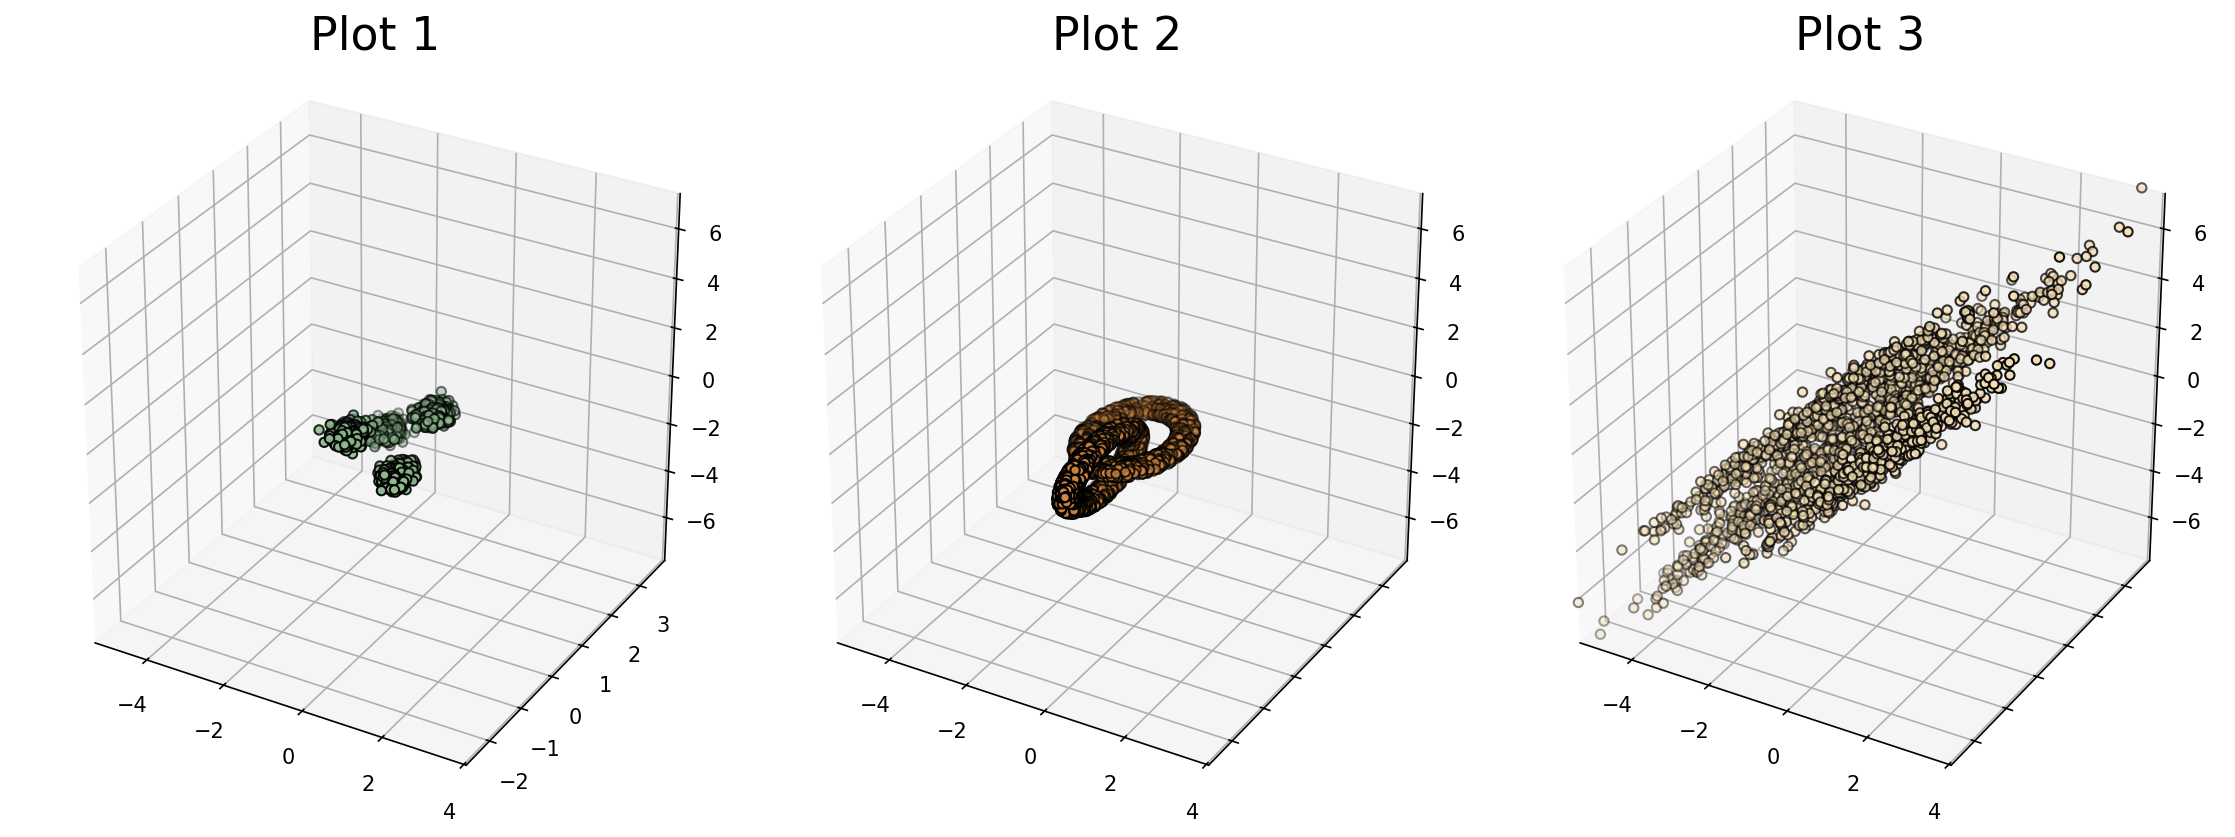

  2%|▏         | 4981/250005 [00:23<17:25, 234.36it/s]

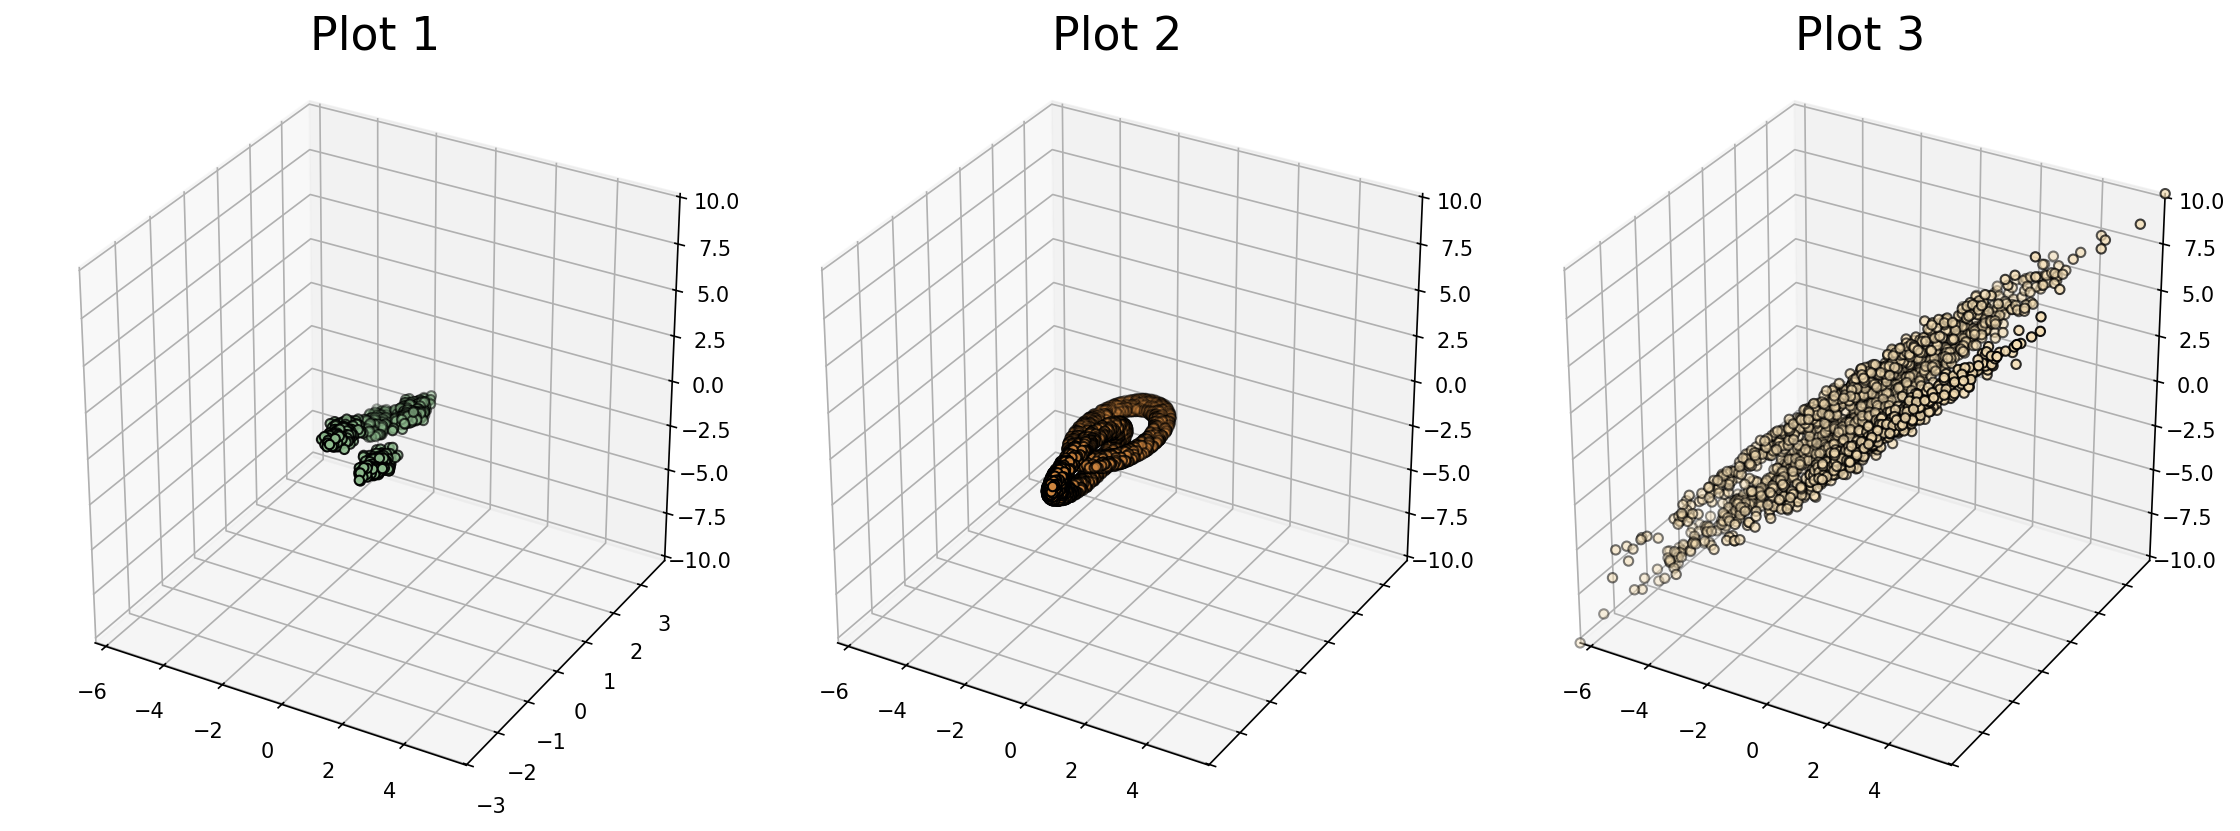

  2%|▏         | 5982/250005 [00:28<18:59, 214.23it/s]

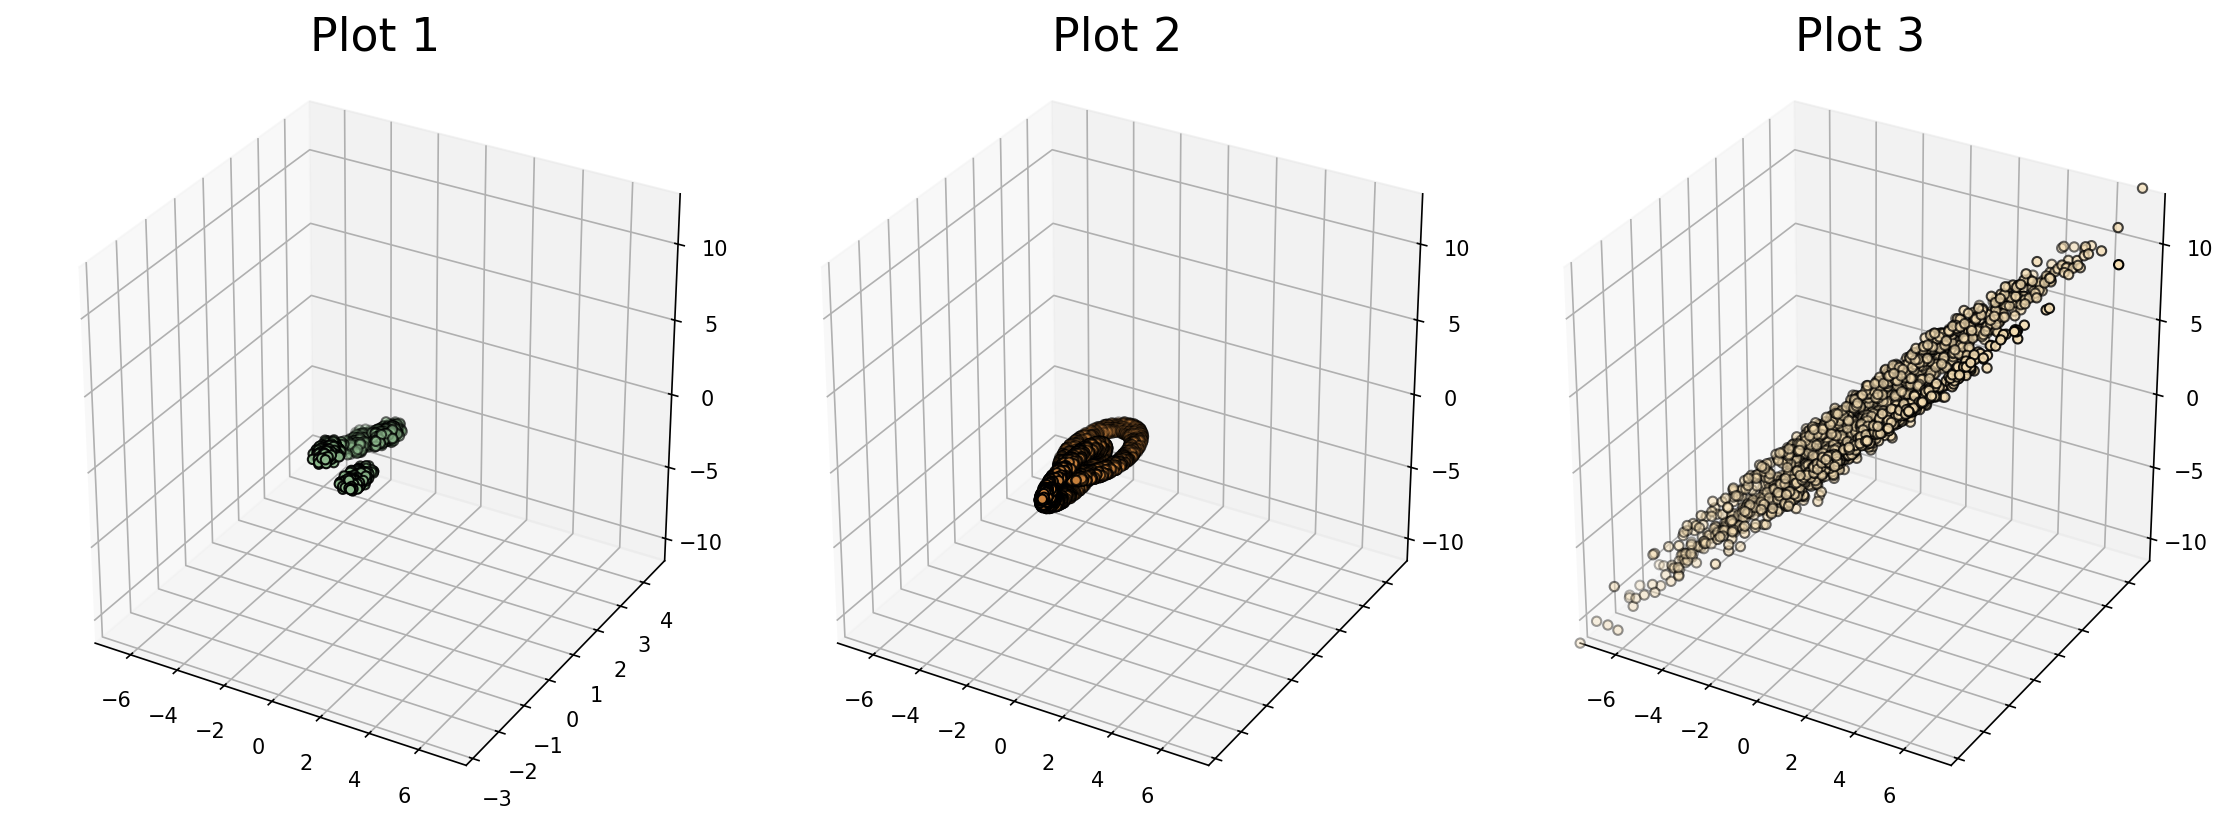

  3%|▎         | 6984/250005 [00:33<18:21, 220.64it/s]

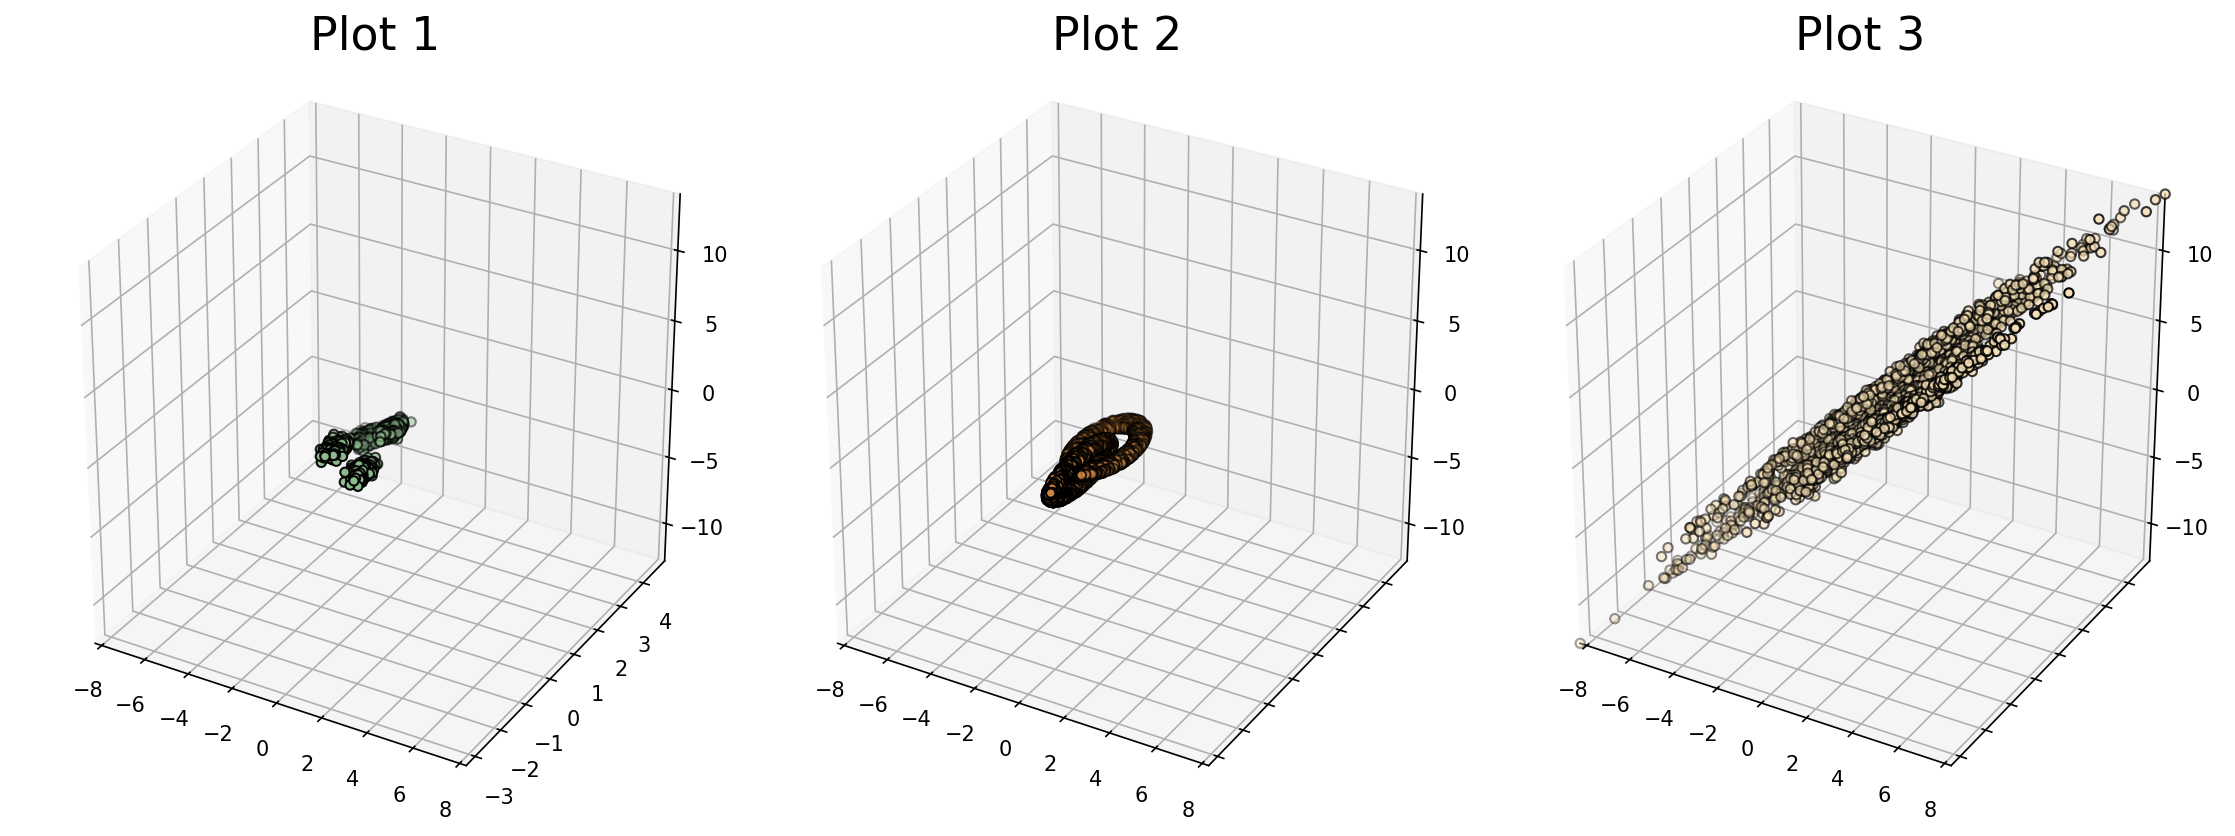

  3%|▎         | 7996/250005 [00:38<18:37, 216.55it/s]

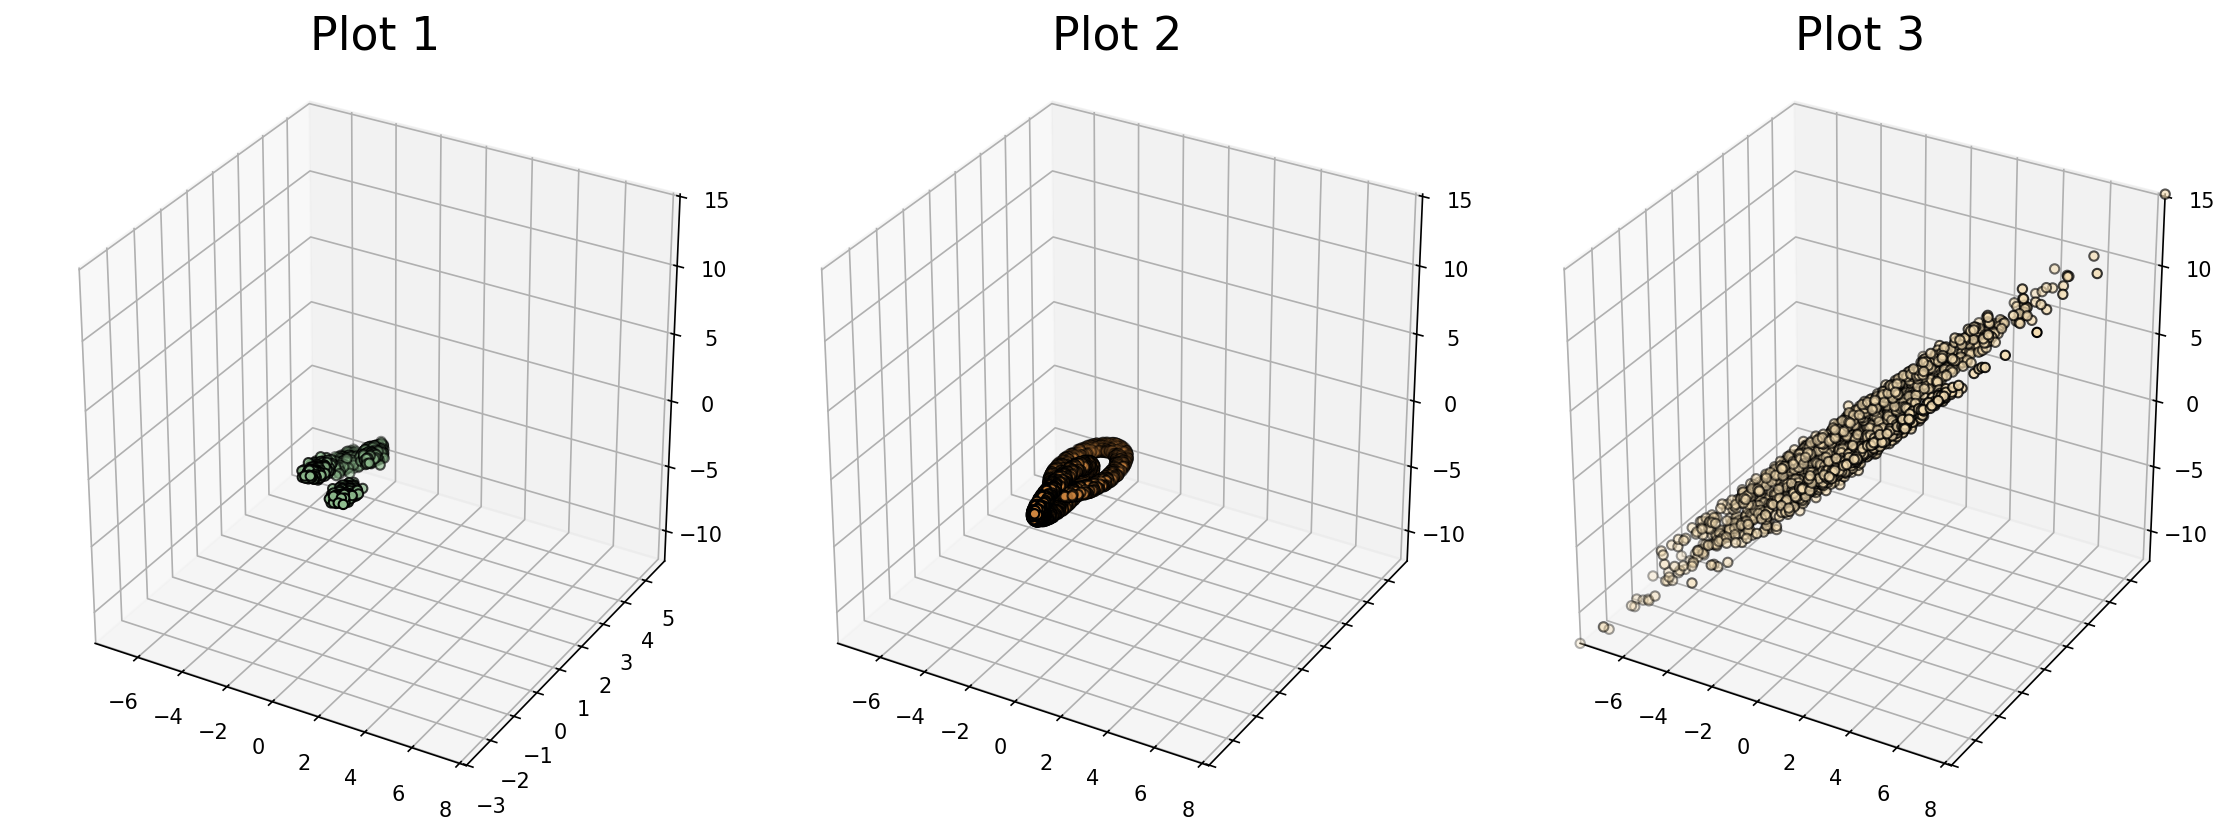

  4%|▎         | 8986/250005 [00:43<18:32, 216.62it/s]

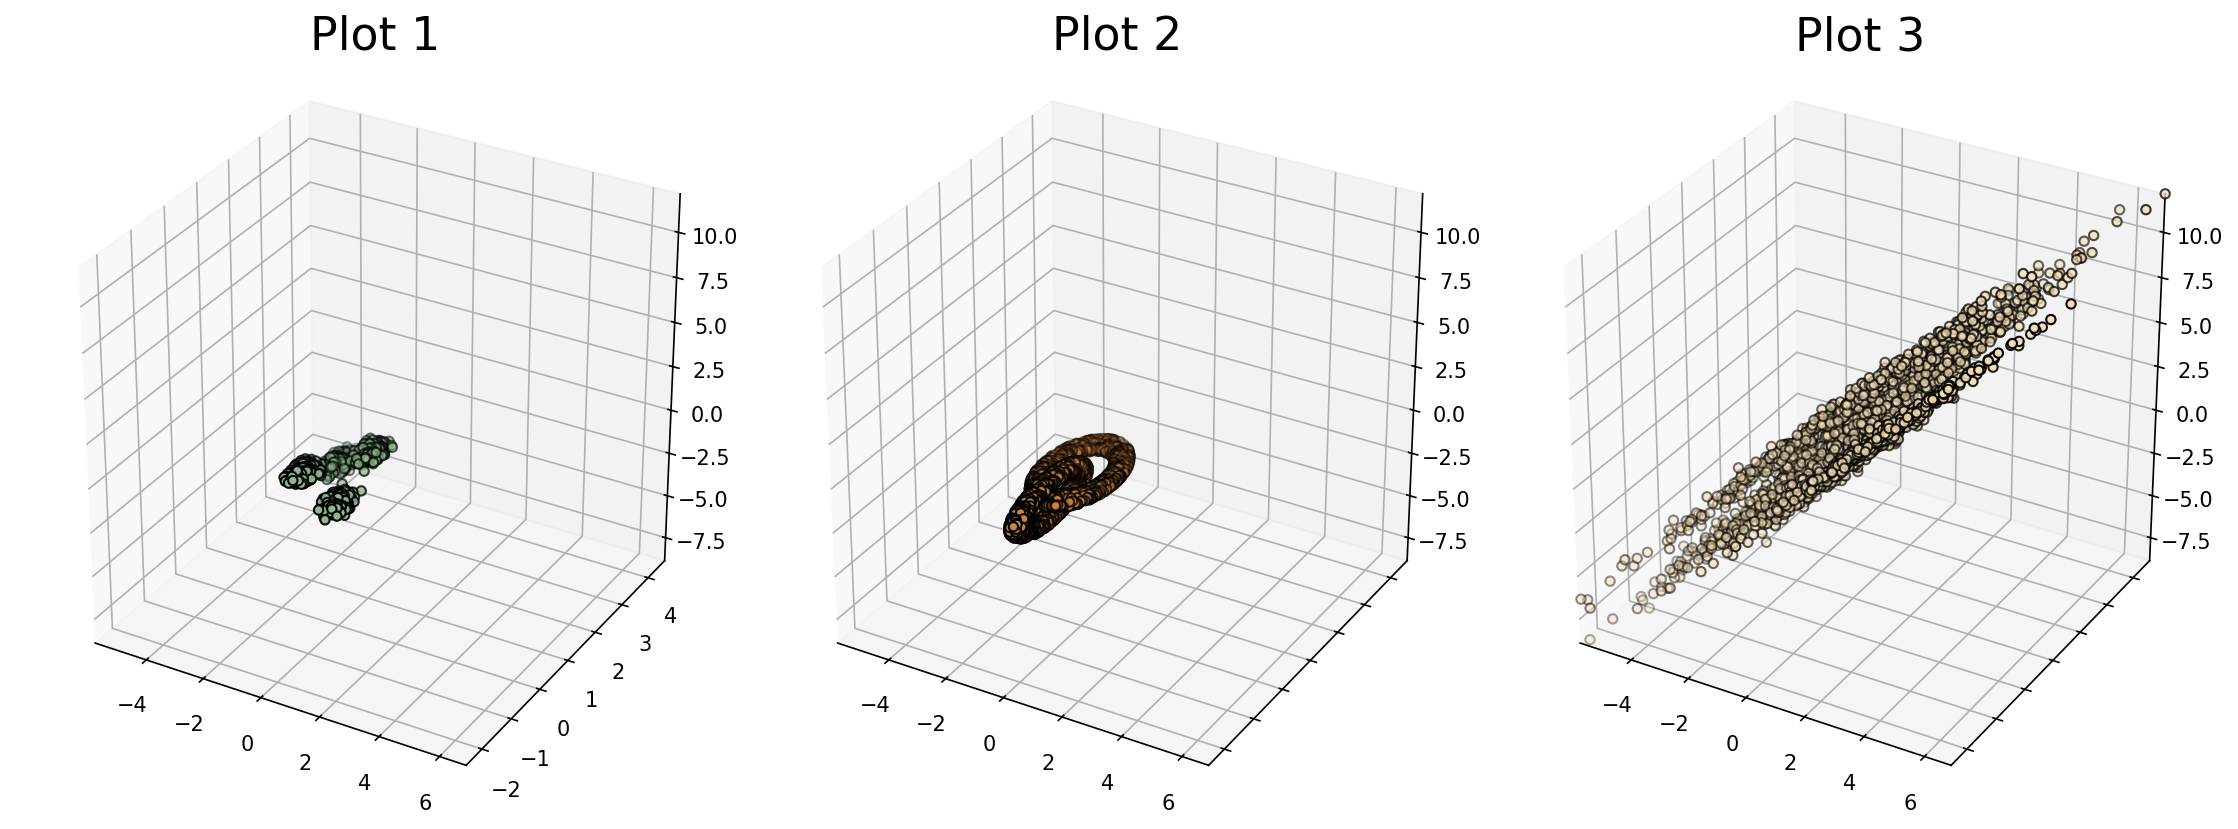

  4%|▍         | 9989/250005 [00:48<18:35, 215.18it/s]

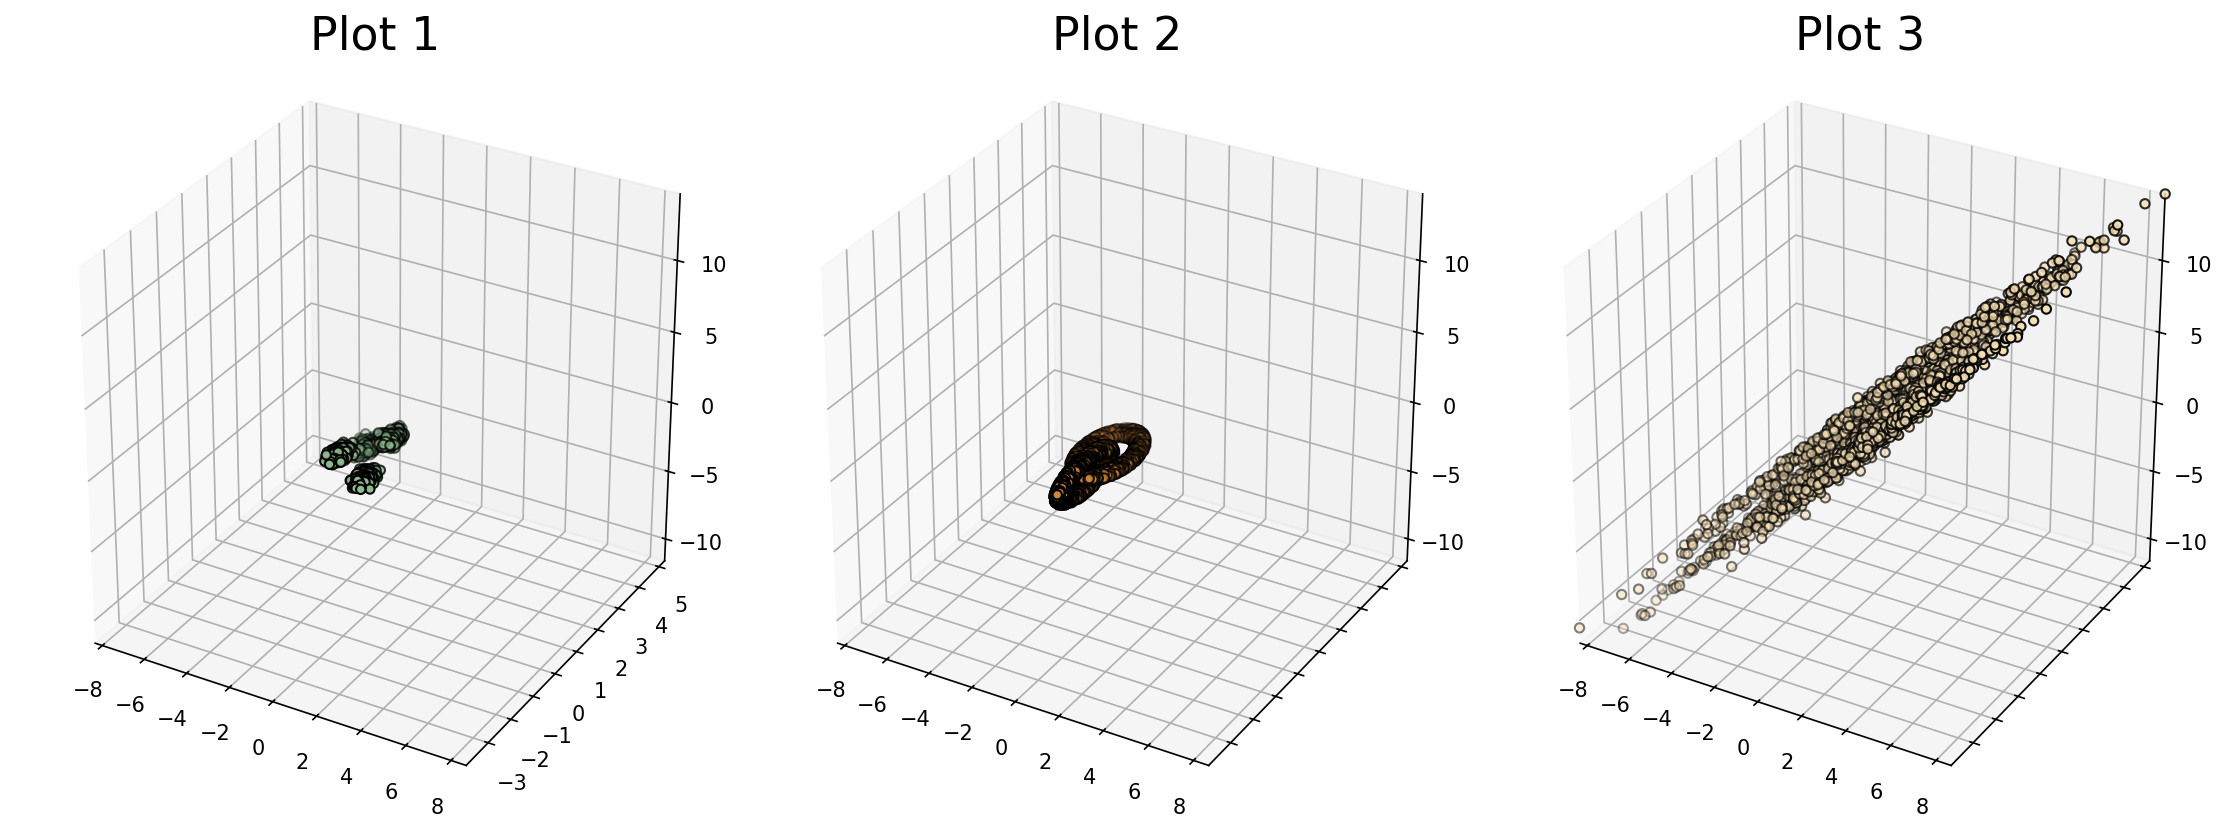

  4%|▍         | 10993/250005 [00:53<16:49, 236.75it/s]

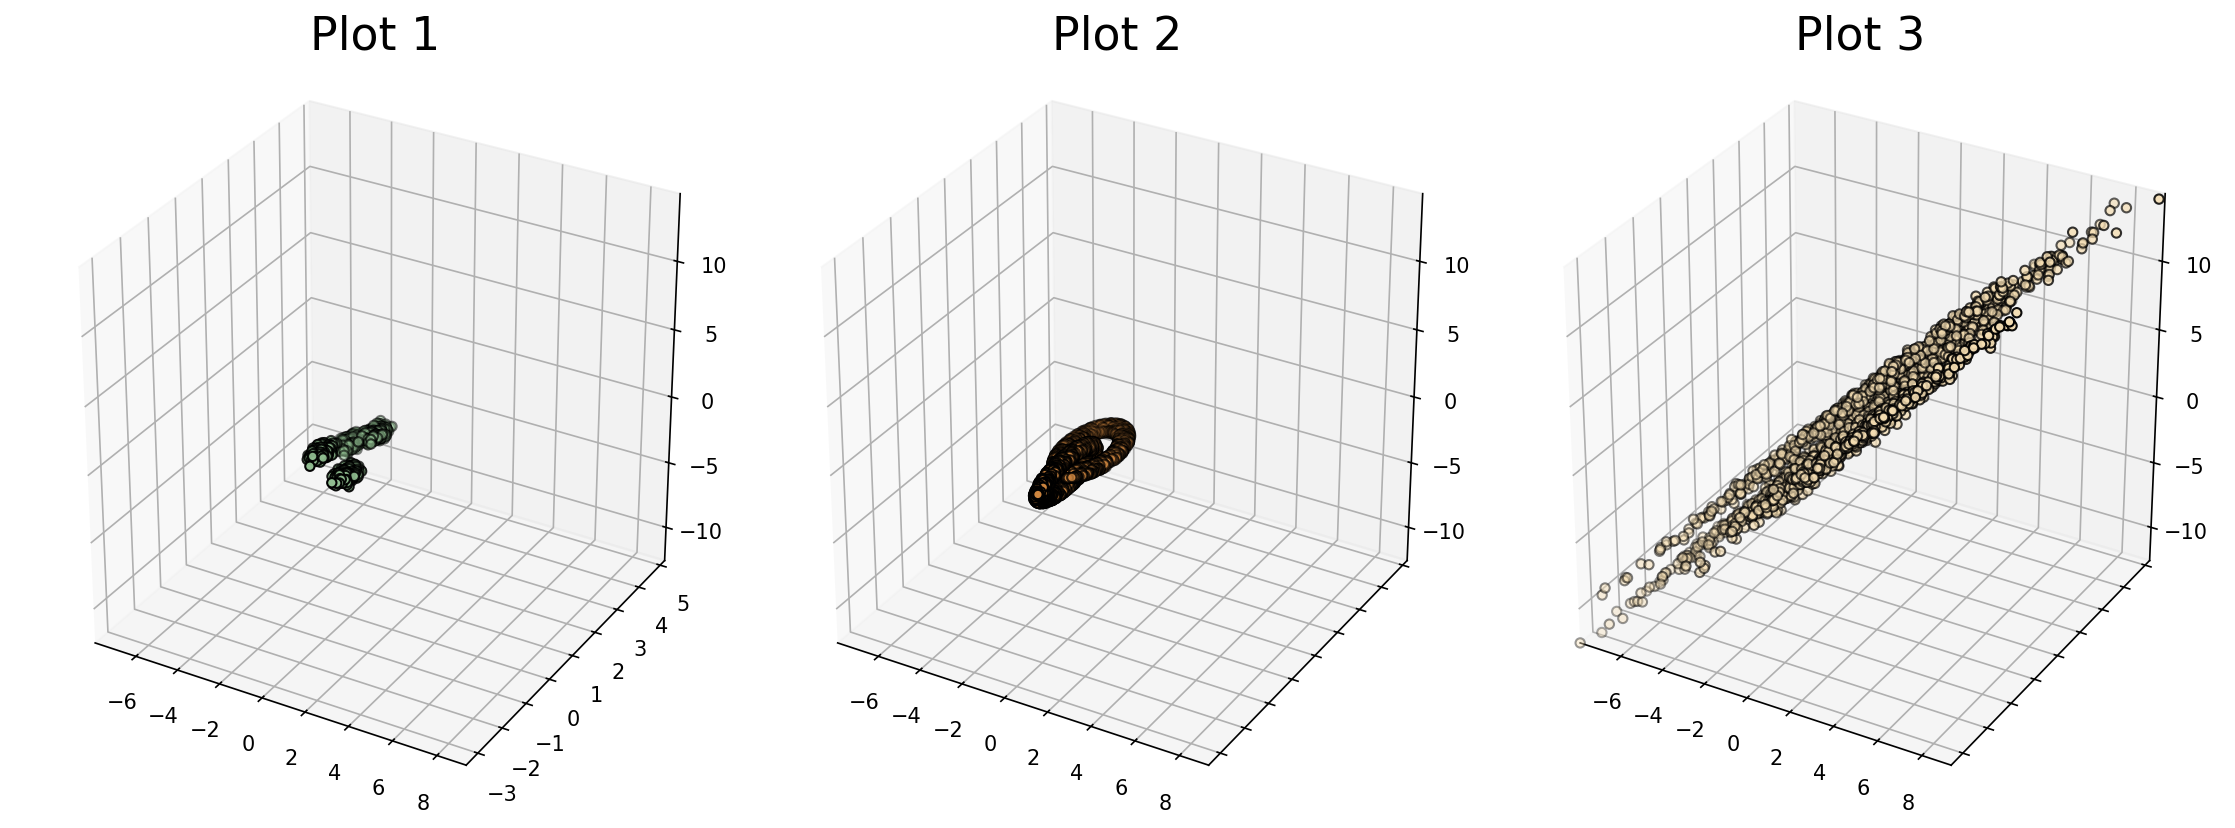

  5%|▍         | 12000/250005 [00:57<16:49, 235.82it/s]

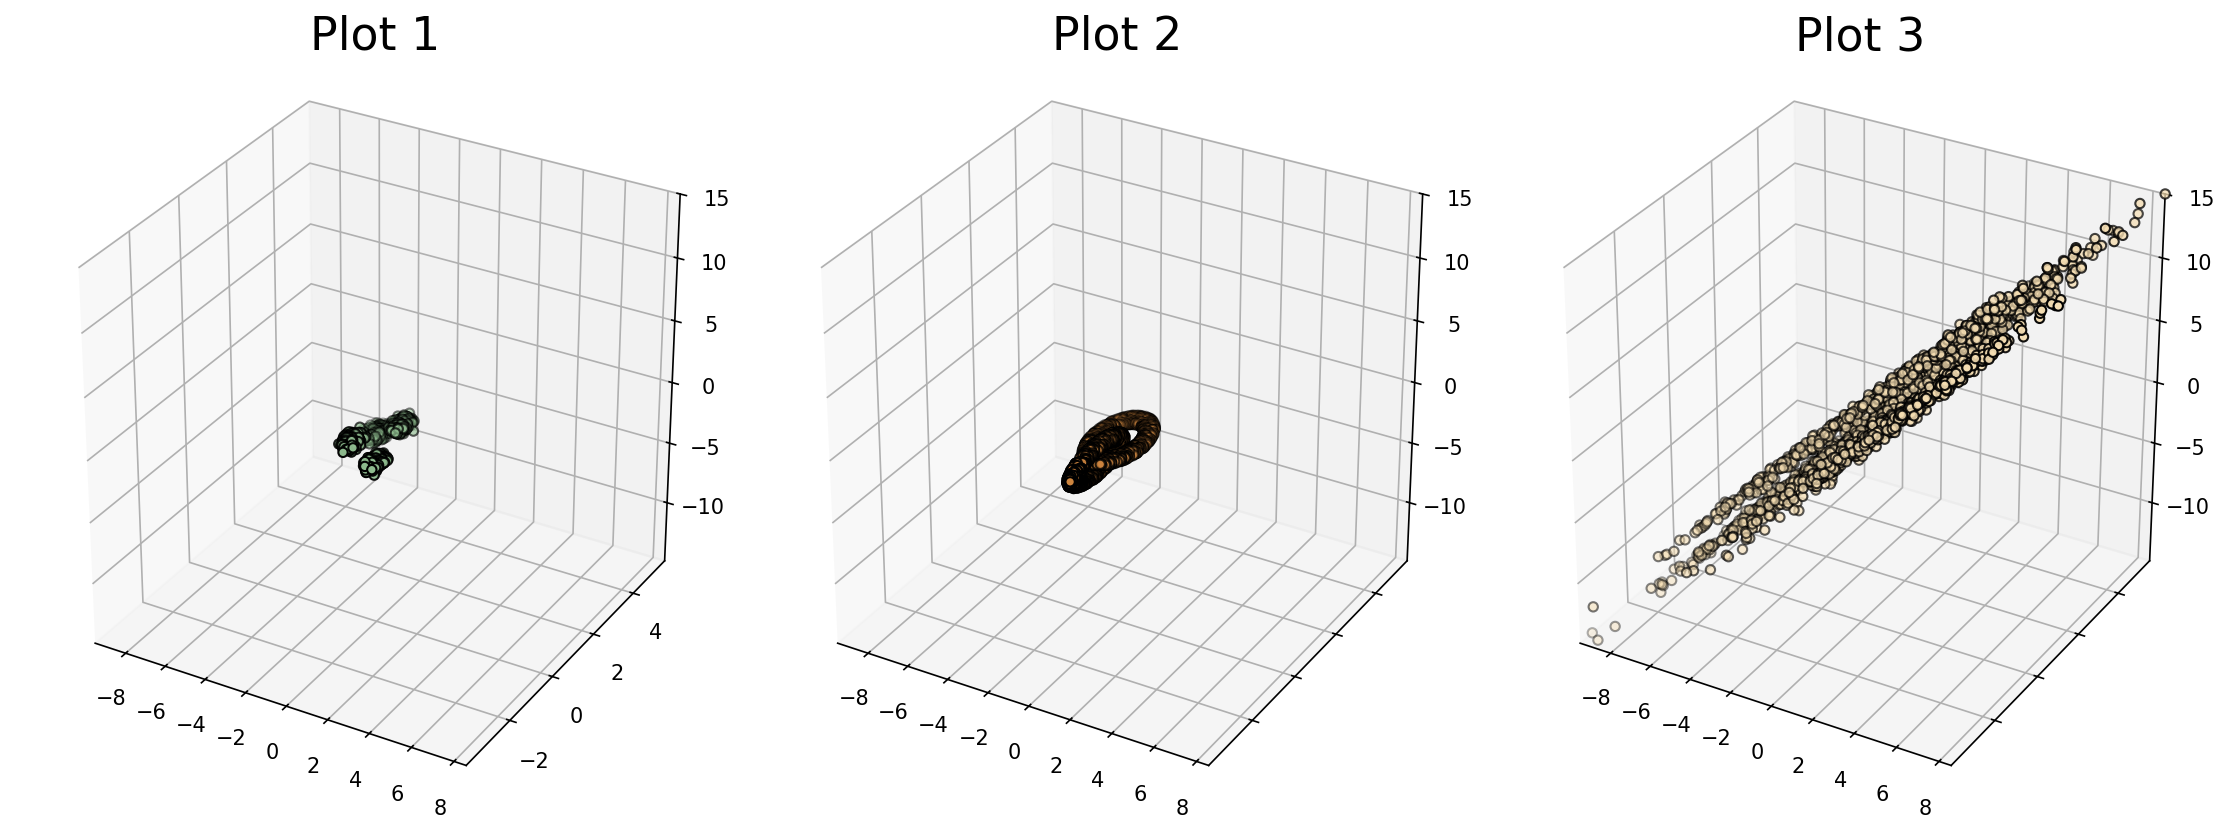

  5%|▍         | 12288/250005 [00:59<17:19, 228.61it/s]

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


T_ITERS = 1
f_LR, T_LR = 1e-5, 1e-5

DIM = 3

ZD = 2
Z_STD = 0.1

BATCH_SIZE = 2048
Z_SIZE = 4

PLOT_INTERVAL = 4000
MAX_STEPS = 50001
SEED = 0x000000


f_loss_list = []
T_loss_list = []


for step in tqdm(range(5*MAX_STEPS)):
    # T optimization  
    n_ot.unfreeze(n_ot.T); n_ot.freeze(n_ot.f)  
    for t_iter in range(T_ITERS):  
        T_opt.zero_grad()  
        X = p_0.sample(BATCH_SIZE).reshape(-1, 1, DIM).repeat(1, Z_SIZE, 1)  
        with torch.no_grad():  
            Z = torch.randn(BATCH_SIZE, Z_SIZE, ZD, device='cuda') * ZD  
            XZ = torch.cat([X, Z], dim=2)  
        T_XZ = n_ot.T(  
            XZ.flatten(start_dim=0, end_dim=1)  
        ).permute(1, 0).reshape(DIM, -1, Z_SIZE).permute(1, 2, 0)  
  
        T_loss = F.mse_loss(X[:, 0], T_XZ.mean(dim=1)).mean() - n_ot.f(  
            T_XZ.flatten(start_dim=0, end_dim=1)).mean() - T_XZ.var(dim=1).mean() / Z_SIZE  
        T_loss_list.append(T_loss.item())
        T_loss.backward()
        T_opt.step()
    
    # f optimization  
    n_ot.freeze(n_ot.T); n_ot.unfreeze(n_ot.f)  
  
    X = p_0.sample(BATCH_SIZE)  
    with torch.no_grad():  
        Z = torch.randn(BATCH_SIZE, ZD, device='cuda') * Z_STD  
        XZ = torch.cat([X, Z], dim=1)  
        T_XZ = n_ot.T(XZ)  
    Y = p_1.sample(BATCH_SIZE)  
  
    f_opt.zero_grad()  
    f_loss = n_ot.f(T_XZ).mean() - n_ot.f(Y).mean() 
    f_loss_list.append(f_loss.item())
    f_loss.backward()  
    if step%1000 == 0:
        plot_generated_3D([
            p_0.sample(batch_size=BATCH_SIZE),
            p_1.sample(batch_size=BATCH_SIZE),
            T_XZ
        ]);
        plt.show()

In [ ]:
import numpy as np

f_loss_list_np = np.array(f_loss_list)
T_loss_list_np = np.array(T_loss_list)

# Define x-axis range based on the length of the numpy arrays  
x = np.arange(len(f_loss_list_np))  
  
# Plot f_loss  
plt.figure(figsize=(10, 6))  
plt.plot(x, f_loss_list_np, label='f_loss')  
plt.plot(x, T_loss_list_np, label='T_loss')  
  
# Define y-axis range based on min and max values of the losses  
plt.ylim([min(np.min(f_loss_list_np), np.min(T_loss_list_np)), max(np.max(f_loss_list_np), np.max(T_loss_list_np))])  
  
# Add labels and title  
plt.xlabel('Epochs')  
plt.ylabel('Loss')  
plt.title('Loss curves for f_loss and T_loss')  
plt.legend()  
  
# Show the plot  
plt.show()  

In [ ]:
# Create a new figure for the scatter plots  
fig, axs = plt.subplots(2, figsize=(10, 20))  
  
# Create the first scatter plot and connect dots  
scatter1 = axs[0].scatter(f_loss_list_np, T_loss_list_np, c=np.arange(len(f_loss_list_np)), cmap='viridis', s=1)  
axs[0].plot(f_loss_list_np, T_loss_list_np, color='grey', linewidth=0.5)  
  
# Add labels and title to the first plot  
axs[0].set_xlabel('f_loss')  
axs[0].set_ylabel('T_loss')  
axs[0].set_title('Scatter plot of T_loss vs f_loss')  
  
# Add colorbar to the first plot  
fig.colorbar(scatter1, ax=axs[0])  
  
# Create the second scatter plot and connect dots  
scatter2 = axs[1].scatter(f_loss_list_np, T_loss_list_np, c=np.arange(len(f_loss_list_np)), cmap='viridis', s=1)  
axs[1].plot(f_loss_list_np, T_loss_list_np, color='black', linewidth=0.5, alpha=0.1)  
  
# Add labels and title to the second plot  
axs[1].set_xlabel('f_loss')  
axs[1].set_ylabel('T_loss')  
axs[1].set_title('Scatter plot of T_loss vs f_loss with equal axis ratio')  
  
# Add colorbar to the second plot  
fig.colorbar(scatter2, ax=axs[1])  
  
# Make the axis ratio equal in the second plot  
axs[1].axis('equal')  
  
# Show the plot  
plt.show()  